# Why AI Gets the “Strawberry” Question Wrong  
**By Jerry Cuomo | Wildducks.us | Jan 18, 2026**

This notebook accompanies the article *Why AI Gets the “Strawberry” Question Wrong*. It walks through a simple but revealing example to explain how language models work, why they sometimes fail at tasks that feel trivial to humans, and how to interact with them more reliably.

The notebook is organized around three teaching points:

1. **AI does not see letters.**  
   Language models convert text into numbers called tokens. Once text is tokenized, individual letters and spelling details largely disappear.

2. **Tokens represent meaning, not spelling.**  
   Tokens are embedded in a high-dimensional space where distance reflects semantic similarity. This space is designed to capture meaning and relationships, not to count characters.

3. **Models answer by prediction, not inspection.**  
   When asked a question, the model predicts a likely continuation based on patterns it has learned, rather than inspecting the input and computing an exact answer.

The notebook then contrasts two related examples:

- **Example A** asks the model directly for an answer, which often produces a confident but incorrect result.
- **Example B** asks the model to break the problem into smaller steps and introduces verification, showing how structured prompts lead to reliable answers, especially for counting or math-like tasks.

Together, these examples demonstrate a practical lesson: when correctness matters, don’t just ask for an answer. Ask for structure that can be checked.

*This code is open source and free to use for academic and educational purposes.*

### Setup: Environment and Dependencies

This cell installs the required libraries and loads API keys from Colab Secrets. To run these examples, you’ll need a Hugging Face token and an OpenAI API key, both of which can be created on their respective websites and added to Colab using the “Secrets” panel. No AI behavior is demonstrated here; this is just the setup.

In [11]:
# Install required packages
!pip install --quiet transformers openai

import os
from google.colab import userdata

# Retrieve API keys from Colab Secrets
hf_token = userdata.get("HF_TOKEN")
openai_key = userdata.get("OPENAI_API_KEY")

# Basic validation
if hf_token is None:
    raise RuntimeError("HF_TOKEN not found in Colab Secrets")

if openai_key is None:
    raise RuntimeError("OPENAI_API_KEY not found in Colab Secrets")

# Expose keys as environment variables for downstream libraries
os.environ["HF_TOKEN"] = hf_token
os.environ["OPENAI_API_KEY"] = openai_key

print("Environment ready: Hugging Face and OpenAI keys loaded.")

Environment ready: Hugging Face and OpenAI keys loaded.


### Teaching Point 1: Tokens, Not Letters

These two cells show what happens before a language model generates any answer.  
The first cell demonstrates how text is broken into tokens, which are chunks of meaning rather than individual letters.  
The second cell shows that those tokens are immediately converted into numbers and represented as a high-dimensional vector that the model operates on mathematically.

In [12]:
from transformers import AutoTokenizer

# Load a GPT-style tokenizer (used consistently across all examples)
tokenizer = AutoTokenizer.from_pretrained("gpt2")

def show_tokens(label, text):
    """Tokenize text and display tokens with their numeric IDs."""
    tokens = tokenizer.tokenize(text)
    token_ids = tokenizer.convert_tokens_to_ids(tokens)

    print(f"\n{label}")
    print("-" * len(label))
    print(text)
    for t, i in zip(tokens, token_ids):
        print(f"{t:>12} -> {i}")

# Example 1: The word by itself
show_tokens("Word only", "strawberry")

# Example 2: The same word in context
show_tokens("Word in context", "strawberry dipped in chocolate")


Word only
---------
strawberry
          st -> 301
         raw -> 1831
       berry -> 8396

Word in context
---------------
strawberry dipped in chocolate
          st -> 301
         raw -> 1831
       berry -> 8396
     Ġdipped -> 35300
         Ġin -> 287
  Ġchocolate -> 11311


In [13]:
import torch
from transformers import AutoModel

# Load the GPT-style model
model = AutoModel.from_pretrained("gpt2")

word = "strawberry"

# Convert the word into model inputs
inputs = tokenizer(word, return_tensors="pt")

# Run the model without tracking gradients
with torch.no_grad():
    outputs = model(**inputs)

# Average token embeddings to get a single vector representation
embedding = outputs.last_hidden_state.mean(dim=1)

print("Embedding shape:", embedding.shape)

Embedding shape: torch.Size([1, 768])


### Teaching Point 2: Tokens Represent Meaning in Space

This example shows how words are represented as points in a high-dimensional meaning space. The first part computes embeddings for related and unrelated words. The second part projects those embeddings into two dimensions so we can visualize how words with similar meanings cluster together.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


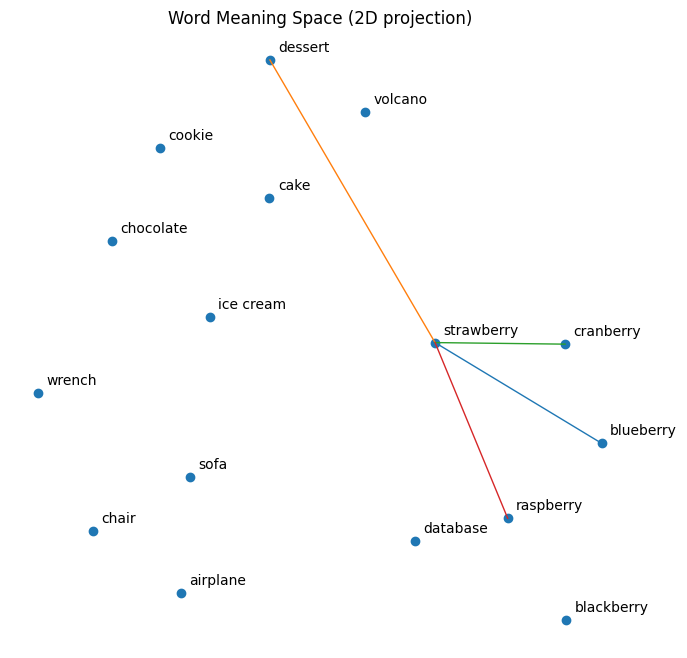

Nearest neighbors of "strawberry" (cosine similarity):
   blueberry  sim=0.631
     dessert  sim=0.572
   cranberry  sim=0.555
   raspberry  sim=0.504


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import umap
from sentence_transformers import SentenceTransformer

# Load a compact sentence embedding model
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# A mix of related and unrelated words
words = [
    # berries / fruit
    "strawberry", "raspberry", "blueberry", "blackberry", "cranberry",
    # desserts / sweets
    "chocolate", "dessert", "cake", "cookie", "ice cream",
    # clearly unrelated
    "chair", "sofa", "airplane", "wrench", "volcano", "database"
]

# Encode words into a high-dimensional meaning space
embeddings = model.encode(words, normalize_embeddings=True)

# Find nearest neighbors of "strawberry" using cosine similarity
target = "strawberry"
t_idx = words.index(target)
similarities = embeddings @ embeddings[t_idx]
ranked = np.argsort(-similarities)
neighbors = [i for i in ranked if i != t_idx][:4]

# Project embeddings down to 2D for visualization
reducer = umap.UMAP(
    n_neighbors=6,
    min_dist=0.25,
    metric="cosine",
    random_state=42
)
coords = reducer.fit_transform(embeddings)

# Plot the projected points
plt.figure(figsize=(8, 8))
plt.scatter(coords[:, 0], coords[:, 1])

# Label points with slight offsets for readability
for i, word in enumerate(words):
    x, y = coords[i]
    plt.annotate(word, (x, y), xytext=(6, 6),
                 textcoords="offset points", fontsize=10)

# Draw lines to nearest neighbors of "strawberry"
sx, sy = coords[t_idx]
for i in neighbors:
    x, y = coords[i]
    plt.plot([sx, x], [sy, y], linewidth=1)

plt.title('Word Meaning Space (2D projection)')
plt.axis("off")
plt.show()

print('Nearest neighbors of "strawberry" (cosine similarity):')
for i in neighbors:
    print(f"  {words[i]:>10}  sim={similarities[i]:.3f}")

### Example A: Asking for an Answer (Prediction Only)

This example mirrors the way most people naturally ask the question. We ask the language model directly for the answer and accept whatever it predicts. As we’ve seen in the article, this often produces a confident but incorrect result.

In [16]:
from openai import OpenAI
from google.colab import userdata

# Initialize OpenAI client
client = OpenAI()

WORD = "strawberry"
LETTER = "r"

def ask(prompt):
    response = client.responses.create(
        model="gpt-4.1-mini",
        input=prompt,
        temperature=0
    )
    return response.output_text.strip()

# Ask the question directly
prompt = f"How many '{LETTER}' letters are in '{WORD}'? Answer with just a number."
answer = ask(prompt)

print("Question:")
print(prompt)
print("\nModel answer:")
print(answer)

Question:
How many 'r' letters are in 'strawberry'? Answer with just a number.

Model answer:
2


### Example B: Asking for Structure (Prediction + Verification)

In this example, we ask the model to break the problem into smaller steps by listing letter positions before giving an answer. This introduces structure that can be checked, turning a fluent guess into a verifiable result.

In [17]:
from openai import OpenAI
from google.colab import userdata
import re

# Initialize OpenAI client
client = OpenAI()

WORD = "strawberry"
LETTER = "r"

# Ground truth for verification
def true_positions(word, letter):
    return [i for i, ch in enumerate(word) if ch == letter]

TRUE_POS = true_positions(WORD, LETTER)

def ask(prompt):
    response = client.responses.create(
        model="gpt-4.1-mini",
        input=prompt,
        temperature=0
    )
    return response.output_text.strip()

def parse_pos(text):
    match = re.search(r"POS\s*=\s*(\[[^\]]*\])", text)
    return eval(match.group(1)) if match else None  # safe here for a controlled demo

# Ask for intermediate structure
prompt = (
    f"List the 0-based index positions of '{LETTER}' in '{WORD}'. "
    "Return only in the form POS=[...]."
)

print("Question:")
print(prompt)

response = ask(prompt)
print("\nModel response:")
print(response)

pos = parse_pos(response)

# Verify and optionally retry
if pos != TRUE_POS:
    print("\nVerification failed. Asking again with feedback.")
    retry_prompt = (
        f"The correct positions are {TRUE_POS}. "
        "Try again and return only POS=[...]."
    )
    retry_response = ask(retry_prompt)
    print("\nRetry response:")
    print(retry_response)

    pos_retry = parse_pos(retry_response)
    if pos_retry == TRUE_POS:
        print("\n✅ Verified correct after retry.")
    else:
        print("\n❌ Still incorrect (showing why verification matters).")
else:
    print("\n✅ Verified correct on first try.")

Question:
List the 0-based index positions of 'r' in 'strawberry'. Return only in the form POS=[...].

Model response:
POS=[2, 8]

Verification failed. Asking again with feedback.

Retry response:
POS=[2, 7, 8]

✅ Verified correct after retry.
